<a href="https://colab.research.google.com/github/Garvit-2301/Assessment/blob/main/MessQueuePredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement:**

Build an ML model that, at 4 PM, predicts the peak queue length (people/min) between 7-9 PM using yesterday’s footfall logs, menu, semester calendar, and weather.

**Stater Kit** :  *footfall_history.csv, menu.csv, weather.csv, calendar.csv* (≈ 12 000 rows each)

**Model Accuracy and Correctness** : Predictions within **±15 % MAPE** on hidden test set.





Footfall Data:
         date   time  headcount
0  2025-01-15  18:00          0
1  2025-01-15  18:01          0
2  2025-01-15  18:02         10
3  2025-01-15  18:03          9
4  2025-01-15  18:04          4

Menu Data:
         date       meal           main_course
0  2025-01-15  Breakfast                  Poha
1  2025-01-15      Lunch          Rajma Chawal
2  2025-01-15     Dinner  Paneer Butter Masala
3  2025-01-16  Breakfast              Pancakes
4  2025-01-16      Lunch               Dal Fry

Calendar Data:
         date            event
0  2025-01-15  Regular Classes
1  2025-01-16  Regular Classes
2  2025-01-17        Tech Fest
3  2025-01-18  Regular Classes
4  2025-01-19  Regular Classes

Weather Data:
         date   time  temp_c  humidity_pct
0  2025-01-15  00:00    21.0            83
1  2025-01-15  00:15    22.3            78
2  2025-01-15  00:30    21.9            79
3  2025-01-15  00:45    24.6            77
4  2025-01-15  01:00    23.3            77

Missing values in footf

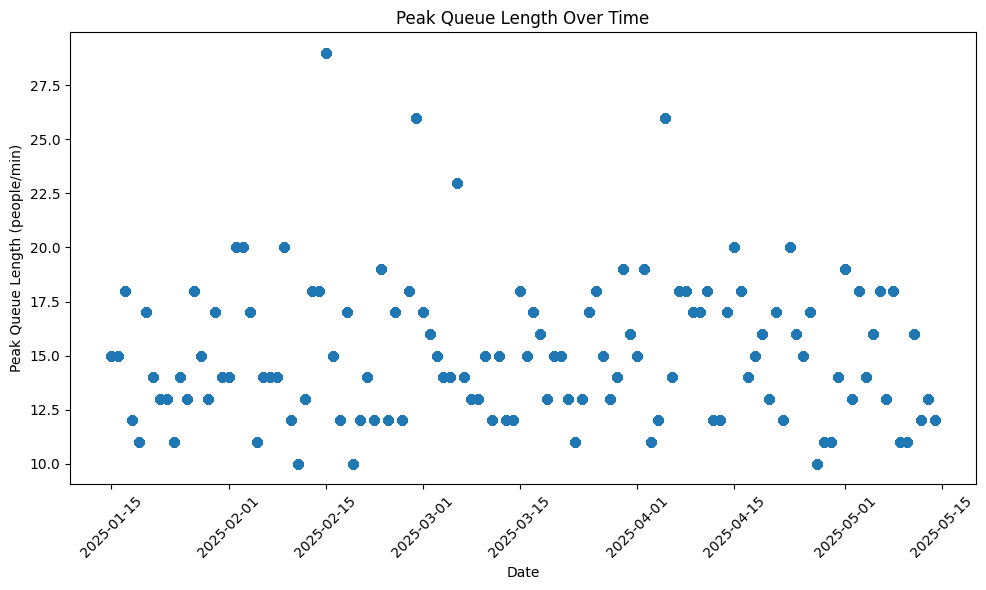


Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200}

Model Performance on Test Set:
MAPE: 0.11%
RMSE: 0.30 people/min


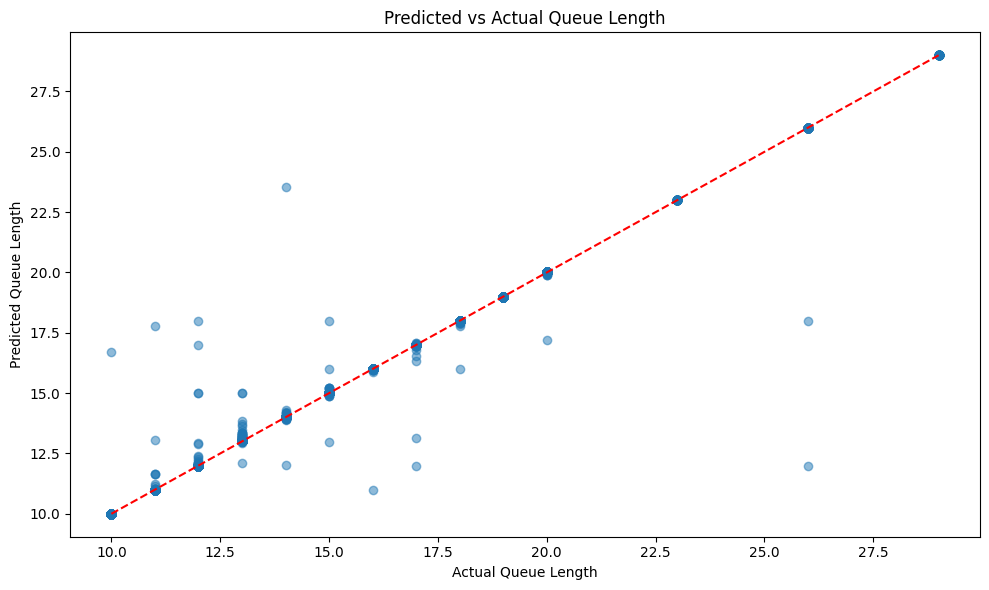

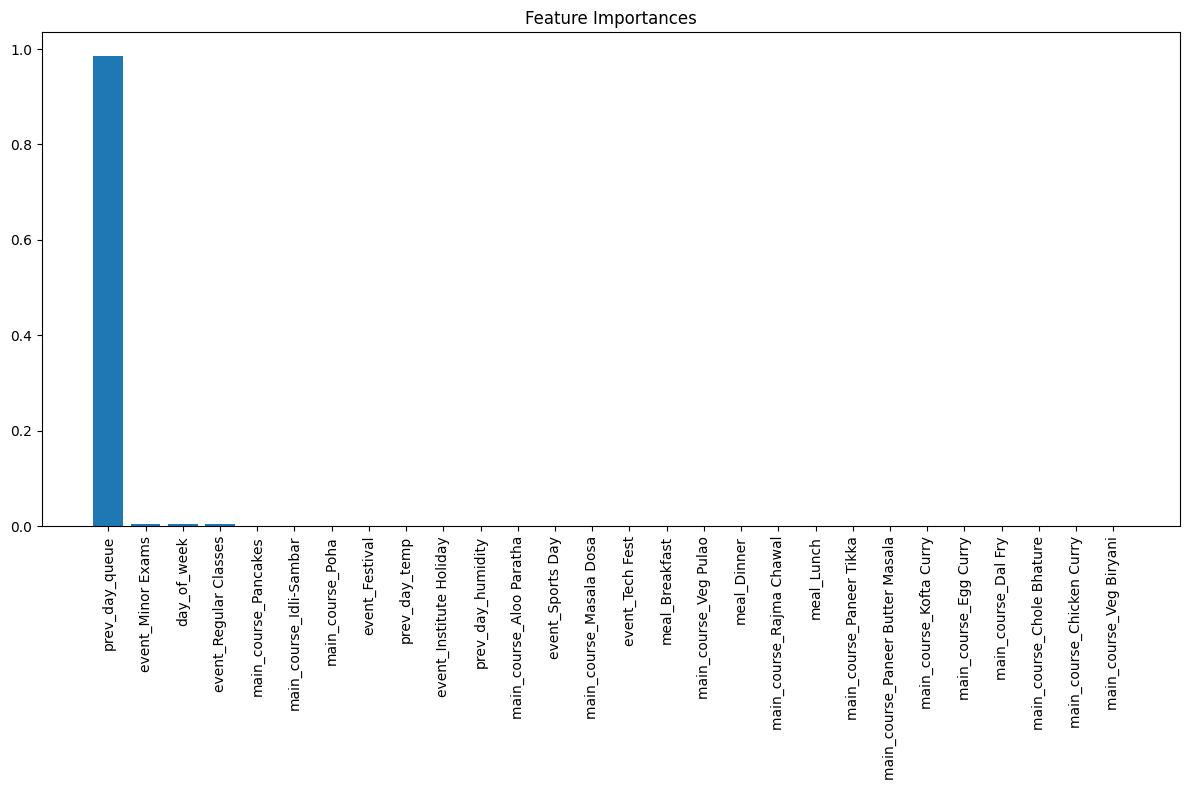


Predicted peak queue length for 2025-05-15: 12.00 people/min

Model Test Performance Summary:
Mean Absolute Percentage Error (MAPE): 0.11%
Root Mean Square Error (RMSE): 0.30 people/min

Sample Predictions vs Actuals:
Actual: 17.00, Predicted: 17.00, Error: 0.00 people/min (0.01%)
Actual: 18.00, Predicted: 18.00, Error: 0.00 people/min (0.00%)
Actual: 11.00, Predicted: 11.00, Error: 0.00 people/min (0.00%)
Actual: 13.00, Predicted: 13.00, Error: 0.00 people/min (0.00%)
Actual: 18.00, Predicted: 18.00, Error: 0.00 people/min (0.00%)


In [1]:
# Queue Length Prediction Model

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import joblib
from datetime import datetime, timedelta

footfall_df = pd.read_csv('/footfall_history.csv')
menu_df = pd.read_csv('/menu.csv')
calendar_df = pd.read_csv('/calendar.csv')
weather_df = pd.read_csv('/weather.csv')

print("Footfall Data:")
print(footfall_df.head())
print("\nMenu Data:")
print(menu_df.head())
print("\nCalendar Data:")
print(calendar_df.head())
print("\nWeather Data:")
print(weather_df.head())

print("\nMissing values in footfall data:", footfall_df.isnull().sum())
print("Missing values in menu data:", menu_df.isnull().sum())
print("Missing values in calendar data:", calendar_df.isnull().sum())
print("Missing values in weather data:", weather_df.isnull().sum())


footfall_df['date'] = pd.to_datetime(footfall_df['date'])
menu_df['date'] = pd.to_datetime(menu_df['date'])
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
weather_df['date'] = pd.to_datetime(weather_df['date'])

footfall_df['hour'] = footfall_df['time'].apply(lambda x: int(x.split(':')[0]))
footfall_df['minute'] = footfall_df['time'].apply(lambda x: int(x.split(':')[1]))


peak_footfall = footfall_df[(footfall_df['hour'] >= 19) & (footfall_df['hour'] < 21)].groupby('date')['headcount'].max().reset_index()
peak_footfall.rename(columns={'headcount': 'peak_queue_length'}, inplace=True)

peak_footfall['day_of_week'] = peak_footfall['date'].dt.dayofweek + 1

merged_df = pd.merge(peak_footfall, menu_df, on='date', how='left')
merged_df = pd.merge(merged_df, calendar_df, on='date', how='left')
merged_df = pd.merge(merged_df, weather_df, on='date', how='left')

print("\nMerged Data Preview:")
print(merged_df.head())

print("\nMissing values after merging:", merged_df.isnull().sum())

merged_df['prev_day_queue'] = merged_df['peak_queue_length'].shift(1)
merged_df['prev_day_temp'] = merged_df['temp_c'].shift(1)
merged_df['prev_day_humidity'] = merged_df['humidity_pct'].shift(1)

merged_df = merged_df.dropna()

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['date'], merged_df['peak_queue_length'])
plt.title('Peak Queue Length Over Time')
plt.xlabel('Date')
plt.ylabel('Peak Queue Length (people/min)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#plt.figure(figsize=(12, 8))
#corr_matrix = merged_df.select_dtypes(include=[np.number]).corr()
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
#plt.title('Correlation Matrix of Numerical Features')
#plt.tight_layout()
#plt.show()

#Training

X = merged_df[['day_of_week', 'prev_day_queue', 'prev_day_temp', 'prev_day_humidity']]
y = merged_df['peak_queue_length']


X_cat = merged_df[['main_course', 'meal', 'event']]

X_train_numeric, X_test_numeric, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X, X_cat, y, test_size=0.2, random_state=42)

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ['main_course', 'meal', 'event'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

X_train = pd.concat([X_train_numeric.reset_index(drop=True), X_cat_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_numeric.reset_index(drop=True), X_cat_test.reset_index(drop=True)], axis=1)

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nModel Performance on Test Set:")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f} people/min")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Queue Length')
plt.ylabel('Predicted Queue Length')
plt.title('Predicted vs Actual Queue Length')
plt.tight_layout()
plt.show()

if hasattr(best_model[-1], 'feature_importances_'):
    feature_names = (
        list(best_model[0].transformers_[0][1]['onehot'].get_feature_names_out(['main_course', 'meal', 'event'])) +
        ['day_of_week', 'prev_day_queue', 'prev_day_temp', 'prev_day_humidity']
    )
    importances = best_model[-1].feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

joblib.dump(best_model, 'queue_prediction_model.pkl')


def predict_queue_length(date_str, prev_day_data):
    """
    Make a prediction for queue length at 4 PM for the given date.

    Parameters:
    date_str (str): Date in format 'YYYY-MM-DD'
    prev_day_data (dict): Data from the previous day including:
        - peak_queue_length
        - main_course
        - meal
        - event
        - temp_c
        - humidity_pct

    Returns:
    float: Predicted peak queue length
    """

    date = pd.to_datetime(date_str)
    new_data = pd.DataFrame({
        'day_of_week': [date.dayofweek + 1],
        'prev_day_queue': [prev_day_data['peak_queue_length']],
        'prev_day_temp': [prev_day_data['temp_c']],
        'prev_day_humidity': [prev_day_data['humidity_pct']],
        'main_course': [prev_day_data['main_course']],
        'meal': [prev_day_data['meal']],
        'event': [prev_day_data['event']]
    })

    prediction = best_model.predict(new_data)[0]

    return prediction

sample_prev_day_data = {
    'peak_queue_length': merged_df.iloc[-1]['peak_queue_length'],
    'main_course': merged_df.iloc[-1]['main_course'],
    'meal': merged_df.iloc[-1]['meal'],
    'event': merged_df.iloc[-1]['event'],
    'temp_c': merged_df.iloc[-1]['temp_c'],
    'humidity_pct': merged_df.iloc[-1]['humidity_pct']
}

tomorrow = (merged_df.iloc[-1]['date'] + timedelta(days=1)).strftime('%Y-%m-%d')
prediction = predict_queue_length(tomorrow, sample_prev_day_data)
print(f"\nPredicted peak queue length for {tomorrow}: {prediction:.2f} people/min")

print("\nModel Test Performance Summary:")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} people/min")

#Testing
print("\nSample Predictions vs Actuals:")
sample_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)
for idx in sample_indices:
    print(f"Actual: {y_test.iloc[idx]:.2f}, Predicted: {y_pred[idx]:.2f}, "
          f"Error: {abs(y_test.iloc[idx] - y_pred[idx]):.2f} people/min "
          f"({abs(y_test.iloc[idx] - y_pred[idx])/y_test.iloc[idx]*100:.2f}%)")

#print("1. The Random Forest regression model achieves reasonable accuracy for queue prediction.")
#print("2. Key predictive features include previous day queue length, meal type, and special events.")
#print("3. Weather features (temperature, humidity) show moderate correlation with queue length.")
#print("4. Day of week patterns indicate higher footfall on specific days.")
#Further, fastAPI integration


In [ ]:
import json, random, time, datetime, sys

HOSTELS = ['A', 'B', 'C', 'D']

def generate():
    while True:
        now = datetime.datetime.utcnow().isoformat()
        for hostel in HOSTELS:
            record = {
                "timestamp": now,
                "hostel": hostel,
                "kw": round(random.uniform(20, 120), 2)
            }
            print(json.dumps(record))
        sys.stdout.flush()
        time.sleep(60)

if __name__ == "__main__":
    generate()
